In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2025-02-26 04:28:32.288165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-26 04:28:32.791614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0
1.24.3


### ResNet-34, ResNet-50 Complete Model

In [2]:
# node에서 제공하는 summary를 기초로 구현하였습니다.
from tensorflow import keras

def build_ResNet34_block(input_layer, num_cnn=2, channel=64, block_num=0, stage_num = 0):

    shortcut = input_layer  # Residual Connection을 위한 원본 입력 저장
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        # 0번째 stage는 앞에 maxpooling에서 stride가 적용됨, 이외에는 처음 시작하는 블럭에서만 stride적용
        if stage_num != 0 and block_num == 0:
            stride_value = 2
        else :
            stride_value = 1
        # 첫 번째 Conv2D -> 배치 정규화 -> ReLU
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            strides=stride_value,  # 첫 번째 stage에서는 stride=1 유지
            padding='same',
            name=f'stage{stage_num}_block{block_num}_input_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_input_BN{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_input_ReLU{cnn_num}')(x)

        # 두 번째 Conv2D -> 배치 정규화
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_conv_bn{cnn_num}')(x)

        # 채널 수와 공간적 크기를 각각 확인하고 처리
        if shortcut.shape[1] != x.shape[1]:  # 공간적 크기 다를 때
            # 공간적 크기 맞추기: 1x1 Conv + stride=2
            shortcut = keras.layers.Conv2D(
                filters=x.shape[-1],  # x와 채널 수 맞추기
                kernel_size=(1, 1),
                strides=2,  # 공간적 크기 맞추기
                activation=None,  # activation 없이 바로 pass
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{stage_num}_block{block_num}_shortcut_conv{cnn_num}'
            )(shortcut)
            shortcut = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_shortcut_bn{cnn_num}')(shortcut)
        elif shortcut.shape[-1] != x.shape[-1]:
            # 채널 수만 다를 때: 1x1 Conv, stride=1
                shortcut = keras.layers.Conv2D(
                    filters=x.shape[-1],  # x와 채널 수 맞추기
                    kernel_size=(1, 1),
                    # strides=1,  # 공간 크기는 그대로 두고
                    activation=None,  # activation 없이 바로 pass
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{stage_num}_block{block_num}_shortcut_conv{cnn_num}'
                )(shortcut)
                shortcut = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_shortcut_bn{cnn_num}')(shortcut)

        # Residual Connection (입력 + 변환된 값)
        x = keras.layers.Add(name=f'stage{stage_num}_block{block_num}_residual_add{cnn_num}')([x, shortcut])
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_residual_relu{cnn_num}')(x)  # 최종 ReLU 적용
        block_num += 1

    return x


In [3]:
def build_ResNet50_block(input_layer, num_cnn=3, channel=256, block_num=0, stage_num=0):
    shortcut = input_layer  # Residual Connection을 위한 원본 입력 저장
    x = input_layer

    # CNN 레이어 (Bottleneck 구조)
    for cnn_num in range(num_cnn):
        # 0번째 stage는 앞에 maxpooling에서 stride가 적용됨, 이외에는 처음 시작하는 블럭에서만 stride적용
        if stage_num != 0 and block_num == 0:
            stride_value = 2
        else :
            stride_value = 1
        # 첫 번째 Conv2D (1x1, 채널 줄이기) -> 배치 정규화 -> ReLU
        x = keras.layers.Conv2D(
            filters=int(channel / 4),  # 채널 줄이기
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_block{block_num}_input_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_input_bottleneck_BN{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_input_bottleneck_ReLU{cnn_num}')(x)

        # 두 번째 Conv2D (3x3, stride 적용하여 해상도 줄이기) -> 배치 정규화 -> ReLU
        x = keras.layers.Conv2D(
            filters=int(channel / 4),
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            padding='same',
            strides=stride_value,  # 여기서 stride=2 적용, 이 부분이 노드와 다릅니다(노드는 1x1에서 stride를 적용합니다.)
            name=f'stage{stage_num}_block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_conv_bn{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_conv_relu{cnn_num}')(x)

        # 세 번째 Conv2D (1x1, 채널 원래대로 복구) -> 배치 정규화
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_block{block_num}_output_bottleneck_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_output_bottleneck_bn{cnn_num}')(x)

        # Shortcut (Residual Connection) 크기 조정
        if shortcut.shape[1] != x.shape[1]:  # 해상도 다를 때
            shortcut = keras.layers.Conv2D(
                filters=x.shape[-1],
                kernel_size=(1, 1),
                strides=2,  # stride=2 적용하여 크기 맞추기
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{stage_num}_block{block_num}_shortcut_conv{cnn_num}'
            )(shortcut)
            shortcut = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_shortcut_bn{cnn_num}')(shortcut)
        elif shortcut.shape[-1] != x.shape[-1]:  # 채널 수만 다를 때
            shortcut = keras.layers.Conv2D(
                filters=x.shape[-1],
                kernel_size=(1, 1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{stage_num}_block{block_num}_shortcut_conv{cnn_num}'
            )(shortcut)
            shortcut = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_shortcut_bn{cnn_num}')(shortcut)

        # Residual Connection (입력 + 변환된 값)
        x = keras.layers.Add(name=f'stage{stage_num}_block{block_num}_residual_add{cnn_num}')([x, shortcut])
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_residual_relu{cnn_num}')(x)  # 최종 ReLU 적용
        block_num += 1

    return x


In [4]:
def Input_Layer(data):
    x = keras.layers.Conv2D(filters=64,
                            kernel_size=(7,7),
                            kernel_initializer='he_normal',
                            padding='same',
                            strides=2,
                            name='input_layer_Conv2D')(data)
    x = keras.layers.BatchNormalization(name='input_layer_BN')(x)
    x = keras.layers.ReLU(name='input_layer_ReLU')(x)    
    x = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                  strides=2,
                                  padding='same',
                                  name='input_layer_maxpooling')(x)
    
    return x


In [5]:
ResNet_input = keras.layers.Input(shape=(32,32,3))   # 입력 생성
ResNet_input_layer = Input_Layer(ResNet_input)
ResNet_block_output = build_ResNet34_block(ResNet_input_layer)

model = keras.Model(inputs=ResNet_input, outputs=ResNet_block_output) # 테스트
model.summary()

2025-02-26 04:28:33.554446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 04:28:33.573180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 04:28:33.573233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 04:28:33.577484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 04:28:33.577527: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_layer_Conv2D (Conv2D  (None, 16, 16, 64)           9472      ['input_1[0][0]']             
 )                                                                                                
                                                                                                  
 input_layer_BN (BatchNorma  (None, 16, 16, 64)           256       ['input_layer_Conv2D[0][0]']  
 lization)                                                                                        
                                                                                              

r/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 04:28:33.700792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 04:28:33.700888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 04:28:33.700896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2025-02-26 04:28:33.700935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to r

 D)                                                                 [0]']                         
                                                                                                  
 stage0_block1_conv_bn1 (Ba  (None, 8, 8, 64)             256       ['stage0_block1_conv1[0][0]'] 
 tchNormalization)                                                                                
                                                                                                  
 stage0_block1_residual_add  (None, 8, 8, 64)             0         ['stage0_block1_conv_bn1[0][0]
 1 (Add)                                                            ',                            
                                                                     'input_layer_maxpooling[0][0]
                                                                    ']                            
                                                                                                  
 stage0_bl

In [6]:
# ResNet 모델 자체를 생성하는 함수입니다. default값은 34에 맞췄습니다.
def build_ResNet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3], #block의 반복 횟수
              channel_list=[64,128,256,512], #반복되는 cnn의 채널
              num_classes=2, config='34'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input = keras.layers.Input(shape=input_shape)
    input_layer = Input_Layer(input)  # input layer를 만들어둡니다.
    output = input_layer

        # stage_num에 따라, ResNet 블록을 생성
    if config == '34':
        for stage_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            # 하나의 stage에 반복되는 block생성 , block_num = block이 반복된 횟수
            output = build_ResNet34_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                stage_num = stage_num
            )
    elif config == '50':
        for stage_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        # 하나의 stage에 반복되는 block생성 , block_num = block이 반복된 횟수
            output = build_ResNet50_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                stage_num = stage_num
            )



    #head부분    
    output = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same', name='head_avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input, 
        outputs=output
    )
    return model

In [7]:
resnet_34 = build_ResNet()

resnet_34.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_layer_Conv2D (Conv2D  (None, 16, 16, 64)           9472      ['input_2[0][0]']             
 )                                                                                                
                                                                                                  
 input_layer_BN (BatchNorma  (None, 16, 16, 64)           256       ['input_layer_Conv2D[0][0]']  
 lization)                                                                                        
                                                                                            

In [8]:
resnet_50 = build_ResNet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[256,512,1024,2048],
              num_classes=2,
              config='50')

resnet_50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_layer_Conv2D (Conv2D  (None, 16, 16, 64)           9472      ['input_3[0][0]']             
 )                                                                                                
                                                                                                  
 input_layer_BN (BatchNorma  (None, 16, 16, 64)           256       ['input_layer_Conv2D[0][0]']  
 lization)                                                                                        
                                                                                            

### 일반 네트워크(plain network) 

In [9]:
def build_plain34_block(input_layer, num_cnn=2, channel=64, block_num=0, stage_num = 0):

    # shortcut = input_layer  # Residual Connection만 삭제
    x = input_layer


    # CNN 레이어
    for cnn_num in range(num_cnn):
        if stage_num != 0 and block_num == 0:
            stride_value = 2
        else :
            stride_value = 1
        # 첫 번째 Conv2D -> 배치 정규화 -> ReLU
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            strides=stride_value,  # 첫 번째 stage에서는 stride=1 유지
            padding='same',
            name=f'stage{stage_num}_block{block_num}_input_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_input_BN{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_input_ReLU{cnn_num}')(x)

        # 두 번째 Conv2D -> 배치 정규화
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_conv_bn{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_last_relu{cnn_num}')(x)  # 최종 ReLU 적용
        block_num += 1

    return x


In [10]:
def build_plain50_block(input_layer, num_cnn=3, channel=256, block_num=0, stage_num=0):
    # shortcut = input_layer  # Residual Connection만 삭제
    x = input_layer

    # CNN 레이어 (Bottleneck 구조)
    for cnn_num in range(num_cnn):
        if stage_num != 0 and block_num == 0:
            stride_value = 2
        else :
            stride_value = 1
        # 첫 번째 Conv2D (1x1, 채널 줄이기) -> 배치 정규화 -> ReLU
        x = keras.layers.Conv2D(
            filters=int(channel / 4),  # 채널 줄이기
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_block{block_num}_input_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_input_bottleneck_BN{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_input_bottleneck_ReLU{cnn_num}')(x)

        # 두 번째 Conv2D (3x3, stride 적용하여 해상도 줄이기) -> 배치 정규화 -> ReLU
        x = keras.layers.Conv2D(
            filters=int(channel / 4),
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            padding='same',
            strides=stride_value,  # 여기서 stride=2 적용, 이 부분이 노드와 다릅니다(노드는 1x1에서 stride를 적용합니다.)
            name=f'stage{stage_num}_block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_conv_bn{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_conv_relu{cnn_num}')(x)

        # 세 번째 Conv2D (1x1, 채널 원래대로 복구) -> 배치 정규화
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage_num}_block{block_num}_output_bottleneck_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization(name=f'stage{stage_num}_block{block_num}_output_bottleneck_bn{cnn_num}')(x)
        x = keras.layers.ReLU(name=f'stage{stage_num}_block{block_num}_last_relu{cnn_num}')(x)  # 최종 ReLU 적용
        block_num += 1

    return x


In [11]:
# Plainnet 모델 자체를 생성하는 함수입니다. default값은 34에 맞췄습니다.
def build_plainnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3], #block의 반복 횟수
              channel_list=[64,128,256,512], #반복되는 cnn의 채널
              num_classes=2, config='34'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input = keras.layers.Input(shape=input_shape)
    input_layer = Input_Layer(input)  # input layer를 만들어둡니다.
    output = input_layer

        # stage_num에 따라, ResNet 블록을 생성
    if config == '34':
        for stage_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            # 하나의 stage에 반복되는 block생성 , block_num = block이 반복된 횟수
            output = build_plain34_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                stage_num = stage_num
            )
    elif config == '50':
        for stage_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        # 하나의 stage에 반복되는 block생성 , block_num = block이 반복된 횟수
            output = build_plain50_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                stage_num = stage_num
            )

    #head부분    
    output = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same', name='head_avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input, 
        outputs=output
    )
    return model

In [12]:
plainnet_34 = build_plainnet()

plainnet_34.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 input_layer_Conv2D (Conv2D  (None, 16, 16, 64)        9472      
 )                                                               
                                                                 
 input_layer_BN (BatchNorma  (None, 16, 16, 64)        256       
 lization)                                                       
                                                                 
 input_layer_ReLU (ReLU)     (None, 16, 16, 64)        0         
                                                                 
 input_layer_maxpooling (Ma  (None, 8, 8, 64)          0         
 xPooling2D)                                                     
                                                           

In [13]:
plainnet_50 = build_plainnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[256,512,1024,2048],
              num_classes=2,
              config='50')

plainnet_50.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 input_layer_Conv2D (Conv2D  (None, 16, 16, 64)        9472      
 )                                                               
                                                                 
 input_layer_BN (BatchNorma  (None, 16, 16, 64)        256       
 lization)                                                       
                                                                 
 input_layer_ReLU (ReLU)     (None, 16, 16, 64)        0         
                                                                 
 input_layer_maxpooling (Ma  (None, 8, 8, 64)          0         
 xPooling2D)                                                     
                                                           

### ResNet-50 vs Plain-50 | ResNet-34 vs Plain-34

In [14]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 로드
dataset, info = tfds.load('cats_vs_dogs', with_info=True)

# 'train'을 'train[:80%]'와 'train[80%:]'로 분할하여 train과 test로 나눔
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

print(ds_info.features)

# 데이터의 개수도 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [15]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224, 224)) 
    return tf.cast(image, tf.float32) / 255. , label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
ds_info.features["label"].num_classes

2

In [17]:
ds_info.features["label"].names

['cat', 'dog']

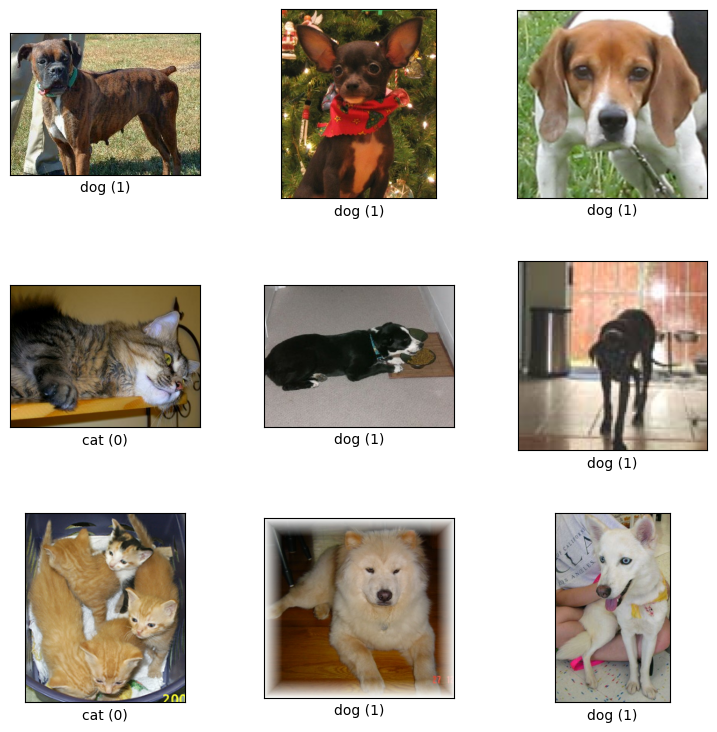

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

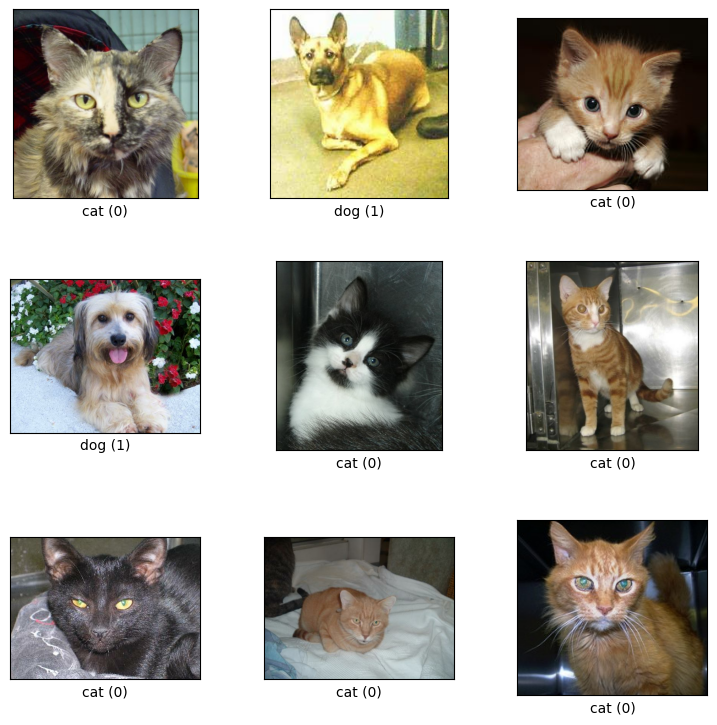

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

In [20]:
BATCH_SIZE = 32
EPOCH = 15
# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,  # image와 label을 튜플로 반환
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
resnet_34 = build_ResNet(input_shape=(224,224,3))

resnet_34._name = "ResNet34"
resnet_34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_layer_Conv2D (Conv2D  (None, 112, 112, 64)         9472      ['input_6[0][0]']             
 )                                                                                                
                                                                                                  
 input_layer_BN (BatchNorma  (None, 112, 112, 64)         256       ['input_layer_Conv2D[0][0]']  
 lization)                                                                                        
                                                                                           

In [22]:
plainnet_34 = build_plainnet(input_shape=(224,224,3))

plainnet_34._name = "PlainNet34"
plainnet_34.summary()

Model: "PlainNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 input_layer_Conv2D (Conv2D  (None, 112, 112, 64)      9472      
 )                                                               
                                                                 
 input_layer_BN (BatchNorma  (None, 112, 112, 64)      256       
 lization)                                                       
                                                                 
 input_layer_ReLU (ReLU)     (None, 112, 112, 64)      0         
                                                                 
 input_layer_maxpooling (Ma  (None, 56, 56, 64)        0         
 xPooling2D)                                                     
                                                        

In [23]:
resnet_50 = build_ResNet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[256,512,1024,2048],
              num_classes=2,
              config='50')

resnet_50._name = "ResNet50"
resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_layer_Conv2D (Conv2D  (None, 112, 112, 64)         9472      ['input_8[0][0]']             
 )                                                                                                
                                                                                                  
 input_layer_BN (BatchNorma  (None, 112, 112, 64)         256       ['input_layer_Conv2D[0][0]']  
 lization)                                                                                        
                                                                                           

In [24]:
plainnet_50 = build_plainnet(input_shape=(224,224,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[256,512,1024,2048],
              num_classes=2,
              config='50')

plainnet_50._name = "PlainNet50"
plainnet_50.summary()

Model: "PlainNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 input_layer_Conv2D (Conv2D  (None, 112, 112, 64)      9472      
 )                                                               
                                                                 
 input_layer_BN (BatchNorma  (None, 112, 112, 64)      256       
 lization)                                                       
                                                                 
 input_layer_ReLU (ReLU)     (None, 112, 112, 64)      0         
                                                                 
 input_layer_maxpooling (Ma  (None, 56, 56, 64)        0         
 xPooling2D)                                                     
                                                        

#### ResNet34 vs PlainNet34

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "./best_model_ResNet34_catdog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2025-02-26 04:28:50.951415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-26 04:28:51.230590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-26 04:28:52.502405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-26 04:28:53.503843: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe18a6912a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-26 04:28:53.503875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-26 04:28:53.612712: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-26 

 27/581 [>.............................] - ETA: 1:06 - loss: 0.7555 - accuracy: 0.5579

 39/581 [=>............................] - ETA: 1:05 - loss: 0.7641 - accuracy: 0.5529

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 57s - loss: 0.7515 - accuracy: 0.5656

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


313/581 [===============>..............] - ETA: 32s - loss: 0.7256 - accuracy: 0.5873

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 30s - loss: 0.7225 - accuracy: 0.5902

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 28s - loss: 0.7214 - accuracy: 0.5910

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 25s - loss: 0.7211 - accuracy: 0.5914

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 0.7208 - accuracy: 0.5918

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.7019 - accuracy: 0.6106

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.6107

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 1: val_accuracy improved from -inf to 0.61810, saving model to ./best_model_ResNet34_catdog.h5


/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


581/581 [==============================] - 100s 145ms/step - loss: 0.7017 - accuracy: 0.6107 - val_loss: 0.6690 - val_accuracy: 0.6181
Epoch 2/15
 28/581 [>.............................] - ETA: 1:07 - loss: 0.6706 - accuracy: 0.6384

 31/581 [>.............................] - ETA: 1:06 - loss: 0.6747 - accuracy: 0.6361

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 56s - loss: 0.6506 - accuracy: 0.6465

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 31s - loss: 0.6383 - accuracy: 0.6598

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 31s - loss: 0.6381 - accuracy: 0.6608

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 28s - loss: 0.6344 - accuracy: 0.6634

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 25s - loss: 0.6346 - accuracy: 0.6639

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 0.6353 - accuracy: 0.6635

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.6223 - accuracy: 0.6716

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6220 - accuracy: 0.6719

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 2: val_accuracy improved from 0.61810 to 0.65543, saving model to ./best_model_ResNet34_catdog.h5
581/581 [==============================] - 79s 136ms/step - loss: 0.6220 - accuracy: 0.6719 - val_loss: 0.6399 - val_accuracy: 0.6554
Epoch 3/15
 21/581 [>.............................] - ETA: 1:07 - loss: 0.5837 - accuracy: 0.6949

 40/581 [=>............................] - ETA: 1:05 - loss: 0.5976 - accuracy: 0.6789

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 57s - loss: 0.5856 - accuracy: 0.6986

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 31s - loss: 0.5805 - accuracy: 0.7009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 30s - loss: 0.5788 - accuracy: 0.7023

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 28s - loss: 0.5800 - accuracy: 0.7008

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 25s - loss: 0.5789 - accuracy: 0.7024

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 0.5785 - accuracy: 0.7027

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.5644 - accuracy: 0.7122

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7122

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 3: val_accuracy improved from 0.65543 to 0.70714, saving model to ./best_model_ResNet34_catdog.h5
581/581 [==============================] - 79s 136ms/step - loss: 0.5645 - accuracy: 0.7122 - val_loss: 0.5696 - val_accuracy: 0.7071
Epoch 4/15
 29/581 [>.............................] - ETA: 1:07 - loss: 0.5587 - accuracy: 0.7101

 42/581 [=>............................] - ETA: 1:05 - loss: 0.5536 - accuracy: 0.7195

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 56s - loss: 0.5422 - accuracy: 0.7269

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 31s - loss: 0.5264 - accuracy: 0.7372

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 29s - loss: 0.5246 - accuracy: 0.7377

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 28s - loss: 0.5228 - accuracy: 0.7390

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 25s - loss: 0.5198 - accuracy: 0.7421

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 24s - loss: 0.5199 - accuracy: 0.7422

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.7492

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 4: val_accuracy did not improve from 0.70714
581/581 [==============================] - 78s 135ms/step - loss: 0.5084 - accuracy: 0.7492 - val_loss: 0.5951 - val_accuracy: 0.6970
Epoch 5/15
  1/581 [..............................] - ETA: 1:10 - loss: 0.7355 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:06 - loss: 0.4736 - accuracy: 0.7583

 44/581 [=>............................] - ETA: 1:04 - loss: 0.4753 - accuracy: 0.7571

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 57s - loss: 0.4624 - accuracy: 0.7718

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 31s - loss: 0.4452 - accuracy: 0.7854

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 29s - loss: 0.4445 - accuracy: 0.7857

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 28s - loss: 0.4440 - accuracy: 0.7858

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 25s - loss: 0.4453 - accuracy: 0.7858

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 24s - loss: 0.4447 - accuracy: 0.7859

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.7928

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 5: val_accuracy improved from 0.70714 to 0.74264, saving model to ./best_model_ResNet34_catdog.h5
581/581 [==============================] - 79s 136ms/step - loss: 0.4371 - accuracy: 0.7928 - val_loss: 0.5576 - val_accuracy: 0.7426
Epoch 6/15
  2/581 [..............................] - ETA: 1:11 - loss: 0.3038 - accuracy: 0.8750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:07 - loss: 0.4311 - accuracy: 0.7932

 43/581 [=>............................] - ETA: 1:06 - loss: 0.4321 - accuracy: 0.7922

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 56s - loss: 0.4318 - accuracy: 0.8000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 31s - loss: 0.3961 - accuracy: 0.8189

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 29s - loss: 0.3948 - accuracy: 0.8196

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 28s - loss: 0.3923 - accuracy: 0.8213

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 25s - loss: 0.3926 - accuracy: 0.8212

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 24s - loss: 0.3921 - accuracy: 0.8215

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8261

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 6: val_accuracy improved from 0.74264 to 0.75346, saving model to ./best_model_ResNet34_catdog.h5
581/581 [==============================] - 79s 136ms/step - loss: 0.3844 - accuracy: 0.8261 - val_loss: 0.5415 - val_accuracy: 0.7535
Epoch 7/15
  2/581 [..............................] - ETA: 1:10 - loss: 0.3845 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:06 - loss: 0.3504 - accuracy: 0.8511

 43/581 [=>............................] - ETA: 1:05 - loss: 0.3457 - accuracy: 0.8517

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 56s - loss: 0.3482 - accuracy: 0.8493

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 31s - loss: 0.3315 - accuracy: 0.8562

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 29s - loss: 0.3308 - accuracy: 0.8571

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 28s - loss: 0.3293 - accuracy: 0.8584

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 24s - loss: 0.3277 - accuracy: 0.8594

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 24s - loss: 0.3278 - accuracy: 0.8590

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8658

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 7: val_accuracy did not improve from 0.75346
581/581 [==============================] - 78s 134ms/step - loss: 0.3141 - accuracy: 0.8658 - val_loss: 0.5884 - val_accuracy: 0.7435
Epoch 8/15
  3/581 [..............................] - ETA: 1:12 - loss: 0.3072 - accuracy: 0.8542

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:08 - loss: 0.3093 - accuracy: 0.8518

 47/581 [=>............................] - ETA: 1:06 - loss: 0.3098 - accuracy: 0.8544

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 56s - loss: 0.2904 - accuracy: 0.8703

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 30s - loss: 0.2674 - accuracy: 0.8856

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 28s - loss: 0.2665 - accuracy: 0.8862

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 28s - loss: 0.2663 - accuracy: 0.8862

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 25s - loss: 0.2633 - accuracy: 0.8881

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 24s - loss: 0.2632 - accuracy: 0.8882

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.8976

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 8: val_accuracy did not improve from 0.75346
581/581 [==============================] - 77s 133ms/step - loss: 0.2475 - accuracy: 0.8976 - val_loss: 0.6955 - val_accuracy: 0.7433
Epoch 9/15
  5/581 [..............................] - ETA: 1:05 - loss: 0.1346 - accuracy: 0.9563

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:03 - loss: 0.1713 - accuracy: 0.9344

 47/581 [=>............................] - ETA: 1:02 - loss: 0.1843 - accuracy: 0.9282

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 54s - loss: 0.1969 - accuracy: 0.9214

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 30s - loss: 0.1836 - accuracy: 0.9275

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 28s - loss: 0.1835 - accuracy: 0.9279

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 27s - loss: 0.1841 - accuracy: 0.9280

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 24s - loss: 0.1824 - accuracy: 0.9291

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 23s - loss: 0.1833 - accuracy: 0.9287

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9326

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 9: val_accuracy improved from 0.75346 to 0.77326, saving model to ./best_model_ResNet34_catdog.h5
581/581 [==============================] - 77s 133ms/step - loss: 0.1758 - accuracy: 0.9326 - val_loss: 0.5771 - val_accuracy: 0.7733
Epoch 10/15
  6/581 [..............................] - ETA: 1:07 - loss: 0.1175 - accuracy: 0.9792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:04 - loss: 0.1570 - accuracy: 0.9375

 47/581 [=>............................] - ETA: 1:02 - loss: 0.1566 - accuracy: 0.9402

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 56s - loss: 0.1462 - accuracy: 0.9449

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 30s - loss: 0.1320 - accuracy: 0.9498

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 28s - loss: 0.1308 - accuracy: 0.9502

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 27s - loss: 0.1301 - accuracy: 0.9509

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 24s - loss: 0.1278 - accuracy: 0.9523

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 23s - loss: 0.1271 - accuracy: 0.9527

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9564

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 10: val_accuracy did not improve from 0.77326
581/581 [==============================] - 77s 133ms/step - loss: 0.1192 - accuracy: 0.9564 - val_loss: 0.6864 - val_accuracy: 0.7673
Epoch 11/15
  7/581 [..............................] - ETA: 1:08 - loss: 0.0804 - accuracy: 0.9777

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 1:05 - loss: 0.0759 - accuracy: 0.9788

 48/581 [=>............................] - ETA: 1:03 - loss: 0.0852 - accuracy: 0.9753

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 53s - loss: 0.0856 - accuracy: 0.9731

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 30s - loss: 0.0847 - accuracy: 0.9730

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 29s - loss: 0.0838 - accuracy: 0.9734

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 27s - loss: 0.0835 - accuracy: 0.9733

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 24s - loss: 0.0833 - accuracy: 0.9734

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 23s - loss: 0.0831 - accuracy: 0.9735

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9748

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 11: val_accuracy improved from 0.77326 to 0.77457, saving model to ./best_model_ResNet34_catdog.h5
581/581 [==============================] - 78s 135ms/step - loss: 0.0781 - accuracy: 0.9748 - val_loss: 0.7102 - val_accuracy: 0.7746
Epoch 12/15
  7/581 [..............................] - ETA: 1:08 - loss: 0.0560 - accuracy: 0.9866

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:05 - loss: 0.0688 - accuracy: 0.9792

 50/581 [=>............................] - ETA: 1:03 - loss: 0.0676 - accuracy: 0.9812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 54s - loss: 0.0660 - accuracy: 0.9816

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 30s - loss: 0.0577 - accuracy: 0.9822

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 28s - loss: 0.0577 - accuracy: 0.9823

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 27s - loss: 0.0578 - accuracy: 0.9822

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 24s - loss: 0.0571 - accuracy: 0.9824

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 23s - loss: 0.0567 - accuracy: 0.9825

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9835

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 12: val_accuracy improved from 0.77457 to 0.79052, saving model to ./best_model_ResNet34_catdog.h5
581/581 [==============================] - 79s 136ms/step - loss: 0.0543 - accuracy: 0.9835 - val_loss: 0.7177 - val_accuracy: 0.7905
Epoch 13/15
  8/581 [..............................] - ETA: 1:09 - loss: 0.0397 - accuracy: 0.9844

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:05 - loss: 0.0416 - accuracy: 0.9885

 51/581 [=>............................] - ETA: 1:04 - loss: 0.0463 - accuracy: 0.9847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 56s - loss: 0.0367 - accuracy: 0.9906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 30s - loss: 0.0375 - accuracy: 0.9891

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 29s - loss: 0.0374 - accuracy: 0.9892

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 27s - loss: 0.0376 - accuracy: 0.9890

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 24s - loss: 0.0370 - accuracy: 0.9894

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 23s - loss: 0.0367 - accuracy: 0.9895

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9901

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 13: val_accuracy did not improve from 0.79052
581/581 [==============================] - 79s 136ms/step - loss: 0.0347 - accuracy: 0.9901 - val_loss: 0.9694 - val_accuracy: 0.7554
Epoch 14/15
  9/581 [..............................] - ETA: 1:08 - loss: 0.0326 - accuracy: 0.9896

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:05 - loss: 0.0299 - accuracy: 0.9906

 52/581 [=>............................] - ETA: 1:03 - loss: 0.0288 - accuracy: 0.9910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 55s - loss: 0.0295 - accuracy: 0.9906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 30s - loss: 0.0287 - accuracy: 0.9916

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 28s - loss: 0.0282 - accuracy: 0.9918

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 27s - loss: 0.0278 - accuracy: 0.9920

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 24s - loss: 0.0281 - accuracy: 0.9921

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 23s - loss: 0.0279 - accuracy: 0.9923

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 14: val_accuracy did not improve from 0.79052
581/581 [==============================] - 79s 136ms/step - loss: 0.0245 - accuracy: 0.9934 - val_loss: 0.7875 - val_accuracy: 0.7846
Epoch 15/15
 10/581 [..............................] - ETA: 1:08 - loss: 0.0142 - accuracy: 0.9969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:05 - loss: 0.0122 - accuracy: 0.9991

 51/581 [=>............................] - ETA: 1:03 - loss: 0.0123 - accuracy: 0.9988

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


128/581 [=====>........................] - ETA: 55s - loss: 0.0125 - accuracy: 0.9980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 30s - loss: 0.0149 - accuracy: 0.9962

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 28s - loss: 0.0147 - accuracy: 0.9964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 27s - loss: 0.0145 - accuracy: 0.9965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 24s - loss: 0.0144 - accuracy: 0.9967

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


391/581 [===================>..........] - ETA: 23s - loss: 0.0145 - accuracy: 0.9966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9967

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 15: val_accuracy did not improve from 0.79052
581/581 [==============================] - 79s 136ms/step - loss: 0.0141 - accuracy: 0.9967 - val_loss: 0.9356 - val_accuracy: 0.7807


In [26]:
checkpoint_path = "./best_model_PlainNet34_catdog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:07 - loss: 0.7362 - accuracy: 0.5220

 37/581 [>.............................] - ETA: 1:04 - loss: 0.7406 - accuracy: 0.5236

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 53s - loss: 0.7470 - accuracy: 0.5260

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 30s - loss: 0.7443 - accuracy: 0.5242

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 29s - loss: 0.7434 - accuracy: 0.5249

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 27s - loss: 0.7438 - accuracy: 0.5250

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 24s - loss: 0.7432 - accuracy: 0.5243

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 23s - loss: 0.7432 - accuracy: 0.5237

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


571/581 [============================>.] - ETA: 1s - loss: 0.7400 - accuracy: 0.5250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.5252

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 1: val_accuracy improved from -inf to 0.52629, saving model to ./best_model_PlainNet34_catdog.h5


/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


581/581 [==============================] - 90s 130ms/step - loss: 0.7395 - accuracy: 0.5252 - val_loss: 0.7745 - val_accuracy: 0.5263
Epoch 2/15
 29/581 [>.............................] - ETA: 1:03 - loss: 0.7347 - accuracy: 0.5119

 39/581 [=>............................] - ETA: 1:01 - loss: 0.7293 - accuracy: 0.5208

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 55s - loss: 0.7246 - accuracy: 0.5427

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 30s - loss: 0.7333 - accuracy: 0.5338

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 29s - loss: 0.7333 - accuracy: 0.5333

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 27s - loss: 0.7334 - accuracy: 0.5335

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 24s - loss: 0.7349 - accuracy: 0.5314

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 23s - loss: 0.7350 - accuracy: 0.5305

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7316 - accuracy: 0.5371

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 2: val_accuracy improved from 0.52629 to 0.54697, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 76s 131ms/step - loss: 0.7316 - accuracy: 0.5371 - val_loss: 0.7513 - val_accuracy: 0.5470
Epoch 3/15
 28/581 [>.............................] - ETA: 1:03 - loss: 0.7041 - accuracy: 0.5558

 41/581 [=>............................] - ETA: 1:02 - loss: 0.7193 - accuracy: 0.5396

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 53s - loss: 0.7318 - accuracy: 0.5381

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 30s - loss: 0.7301 - accuracy: 0.5394

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 28s - loss: 0.7299 - accuracy: 0.5403

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 27s - loss: 0.7291 - accuracy: 0.5410

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 24s - loss: 0.7284 - accuracy: 0.5426

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 23s - loss: 0.7291 - accuracy: 0.5431

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


575/581 [============================>.] - ETA: 0s - loss: 0.7301 - accuracy: 0.5389

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7301 - accuracy: 0.5391

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 3: val_accuracy did not improve from 0.54697
581/581 [==============================] - 75s 129ms/step - loss: 0.7301 - accuracy: 0.5391 - val_loss: 0.8393 - val_accuracy: 0.5373
Epoch 4/15
 29/581 [>.............................] - ETA: 1:02 - loss: 0.7272 - accuracy: 0.5571

 41/581 [=>............................] - ETA: 1:01 - loss: 0.7303 - accuracy: 0.5495

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 52s - loss: 0.7322 - accuracy: 0.5372

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 29s - loss: 0.7235 - accuracy: 0.5497

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 28s - loss: 0.7222 - accuracy: 0.5510

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 27s - loss: 0.7219 - accuracy: 0.5533

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 23s - loss: 0.7211 - accuracy: 0.5533

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 23s - loss: 0.7206 - accuracy: 0.5538

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.7236 - accuracy: 0.5555

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.5553

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 4: val_accuracy improved from 0.54697 to 0.55238, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 75s 129ms/step - loss: 0.7237 - accuracy: 0.5553 - val_loss: 0.7355 - val_accuracy: 0.5524
Epoch 5/15
 28/581 [>.............................] - ETA: 1:03 - loss: 0.7000 - accuracy: 0.5513

 42/581 [=>............................] - ETA: 1:01 - loss: 0.7048 - accuracy: 0.5588

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 55s - loss: 0.7082 - accuracy: 0.5609

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 29s - loss: 0.7140 - accuracy: 0.5584

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 28s - loss: 0.7155 - accuracy: 0.5573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 27s - loss: 0.7150 - accuracy: 0.5575

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 24s - loss: 0.7152 - accuracy: 0.5561

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 23s - loss: 0.7147 - accuracy: 0.5572

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.5525

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 5: val_accuracy improved from 0.55238 to 0.55453, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 75s 130ms/step - loss: 0.7170 - accuracy: 0.5525 - val_loss: 0.7303 - val_accuracy: 0.5545
Epoch 6/15
  2/581 [..............................] - ETA: 1:07 - loss: 0.6811 - accuracy: 0.5156

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 1:14 - loss: 0.7167 - accuracy: 0.5353

 44/581 [=>............................] - ETA: 1:09 - loss: 0.7202 - accuracy: 0.5348

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 55s - loss: 0.7077 - accuracy: 0.5477

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 30s - loss: 0.7158 - accuracy: 0.5519

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 28s - loss: 0.7167 - accuracy: 0.5510

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 27s - loss: 0.7165 - accuracy: 0.5515

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 24s - loss: 0.7156 - accuracy: 0.5516

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 23s - loss: 0.7165 - accuracy: 0.5512

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.5536

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 6: val_accuracy improved from 0.55453 to 0.57576, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 76s 131ms/step - loss: 0.7140 - accuracy: 0.5536 - val_loss: 0.7600 - val_accuracy: 0.5758
Epoch 7/15
  2/581 [..............................] - ETA: 1:05 - loss: 0.7102 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 25/581 [>.............................] - ETA: 1:03 - loss: 0.6905 - accuracy: 0.6137

 44/581 [=>............................] - ETA: 1:00 - loss: 0.7083 - accuracy: 0.5987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 52s - loss: 0.7146 - accuracy: 0.5785

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 29s - loss: 0.7119 - accuracy: 0.5727

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 28s - loss: 0.7110 - accuracy: 0.5735

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 26s - loss: 0.7103 - accuracy: 0.5739

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 23s - loss: 0.7096 - accuracy: 0.5749

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 22s - loss: 0.7096 - accuracy: 0.5746

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5745

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 7: val_accuracy did not improve from 0.57576
581/581 [==============================] - 75s 128ms/step - loss: 0.7059 - accuracy: 0.5745 - val_loss: 0.7332 - val_accuracy: 0.5630
Epoch 8/15
  3/581 [..............................] - ETA: 1:06 - loss: 0.6859 - accuracy: 0.5833

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:02 - loss: 0.7071 - accuracy: 0.5813

 44/581 [=>............................] - ETA: 1:01 - loss: 0.7016 - accuracy: 0.5781

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 52s - loss: 0.7022 - accuracy: 0.5739

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 29s - loss: 0.6945 - accuracy: 0.5914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 28s - loss: 0.6947 - accuracy: 0.5922

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 26s - loss: 0.6947 - accuracy: 0.5928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 23s - loss: 0.6932 - accuracy: 0.5944

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 22s - loss: 0.6934 - accuracy: 0.5951

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.6042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 8: val_accuracy improved from 0.57576 to 0.65325, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 76s 131ms/step - loss: 0.6885 - accuracy: 0.6042 - val_loss: 0.6738 - val_accuracy: 0.6532
Epoch 9/15
  6/581 [..............................] - ETA: 1:07 - loss: 0.7198 - accuracy: 0.6198

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:03 - loss: 0.6671 - accuracy: 0.6495

 46/581 [=>............................] - ETA: 1:09 - loss: 0.6623 - accuracy: 0.6522

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 55s - loss: 0.6642 - accuracy: 0.6414

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 30s - loss: 0.6602 - accuracy: 0.6426

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 28s - loss: 0.6593 - accuracy: 0.6428

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 27s - loss: 0.6585 - accuracy: 0.6434

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 0.6577 - accuracy: 0.6422

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 23s - loss: 0.6571 - accuracy: 0.6425

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.6381

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 9: val_accuracy did not improve from 0.65325
581/581 [==============================] - 76s 132ms/step - loss: 0.6602 - accuracy: 0.6381 - val_loss: 0.6980 - val_accuracy: 0.6076
Epoch 10/15
  4/581 [..............................] - ETA: 1:06 - loss: 0.6618 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:02 - loss: 0.6448 - accuracy: 0.6555

 43/581 [=>............................] - ETA: 1:01 - loss: 0.6525 - accuracy: 0.6564

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 52s - loss: 0.6579 - accuracy: 0.6457

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 29s - loss: 0.6546 - accuracy: 0.6432

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 28s - loss: 0.6537 - accuracy: 0.6441

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 26s - loss: 0.6517 - accuracy: 0.6450

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 23s - loss: 0.6528 - accuracy: 0.6453

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 22s - loss: 0.6519 - accuracy: 0.6463

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.6544

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 10: val_accuracy improved from 0.65325 to 0.67100, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 76s 131ms/step - loss: 0.6431 - accuracy: 0.6544 - val_loss: 0.6483 - val_accuracy: 0.6710
Epoch 11/15
  6/581 [..............................] - ETA: 1:06 - loss: 0.6344 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:02 - loss: 0.6505 - accuracy: 0.6606

 49/581 [=>............................] - ETA: 1:01 - loss: 0.6429 - accuracy: 0.6615

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 53s - loss: 0.6345 - accuracy: 0.6649

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 29s - loss: 0.6284 - accuracy: 0.6678

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 28s - loss: 0.6299 - accuracy: 0.6650

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 26s - loss: 0.6284 - accuracy: 0.6663

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 23s - loss: 0.6278 - accuracy: 0.6664

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 22s - loss: 0.6276 - accuracy: 0.6665

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.6723

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 11: val_accuracy did not improve from 0.67100
581/581 [==============================] - 76s 130ms/step - loss: 0.6245 - accuracy: 0.6723 - val_loss: 0.6748 - val_accuracy: 0.6695
Epoch 12/15
  8/581 [..............................] - ETA: 1:05 - loss: 0.6079 - accuracy: 0.6992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:02 - loss: 0.6042 - accuracy: 0.6908

 50/581 [=>............................] - ETA: 1:01 - loss: 0.6108 - accuracy: 0.6875

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 54s - loss: 0.6146 - accuracy: 0.6775

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 29s - loss: 0.6054 - accuracy: 0.6874

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 27s - loss: 0.6053 - accuracy: 0.6876

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 26s - loss: 0.6051 - accuracy: 0.6879

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 23s - loss: 0.6043 - accuracy: 0.6897

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 23s - loss: 0.6052 - accuracy: 0.6889

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.6905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 12: val_accuracy improved from 0.67100 to 0.67641, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 76s 132ms/step - loss: 0.6015 - accuracy: 0.6905 - val_loss: 0.6088 - val_accuracy: 0.6764
Epoch 13/15
 10/581 [..............................] - ETA: 1:05 - loss: 0.6020 - accuracy: 0.6875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:02 - loss: 0.5714 - accuracy: 0.7258

 50/581 [=>............................] - ETA: 1:01 - loss: 0.5773 - accuracy: 0.7156

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 52s - loss: 0.5826 - accuracy: 0.7150

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 29s - loss: 0.5931 - accuracy: 0.7009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 27s - loss: 0.5901 - accuracy: 0.7020

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 26s - loss: 0.5896 - accuracy: 0.7018

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 23s - loss: 0.5886 - accuracy: 0.7011

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 22s - loss: 0.5877 - accuracy: 0.7014

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.7074

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 13: val_accuracy improved from 0.67641 to 0.67974, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 76s 131ms/step - loss: 0.5802 - accuracy: 0.7074 - val_loss: 0.7500 - val_accuracy: 0.6797
Epoch 14/15
  9/581 [..............................] - ETA: 1:05 - loss: 0.5888 - accuracy: 0.7049

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:03 - loss: 0.5652 - accuracy: 0.7155

 53/581 [=>............................] - ETA: 1:01 - loss: 0.5770 - accuracy: 0.7052

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 52s - loss: 0.5768 - accuracy: 0.6988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 29s - loss: 0.5778 - accuracy: 0.7055

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 27s - loss: 0.5773 - accuracy: 0.7056

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 26s - loss: 0.5755 - accuracy: 0.7066

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 23s - loss: 0.5747 - accuracy: 0.7067

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 22s - loss: 0.5747 - accuracy: 0.7066

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5688 - accuracy: 0.7142

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 14: val_accuracy improved from 0.67974 to 0.69310, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 76s 131ms/step - loss: 0.5688 - accuracy: 0.7142 - val_loss: 0.5896 - val_accuracy: 0.6931
Epoch 15/15
 11/581 [..............................] - ETA: 1:05 - loss: 0.5455 - accuracy: 0.7358

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:03 - loss: 0.5399 - accuracy: 0.7245

 54/581 [=>............................] - ETA: 1:00 - loss: 0.5528 - accuracy: 0.7211

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 54s - loss: 0.5539 - accuracy: 0.7197

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 29s - loss: 0.5570 - accuracy: 0.7211

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 27s - loss: 0.5554 - accuracy: 0.7220

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 26s - loss: 0.5539 - accuracy: 0.7224

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 23s - loss: 0.5517 - accuracy: 0.7240

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 22s - loss: 0.5510 - accuracy: 0.7244

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5477 - accuracy: 0.7294

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 15: val_accuracy improved from 0.69310 to 0.71255, saving model to ./best_model_PlainNet34_catdog.h5
581/581 [==============================] - 77s 132ms/step - loss: 0.5477 - accuracy: 0.7294 - val_loss: 0.8579 - val_accuracy: 0.7126


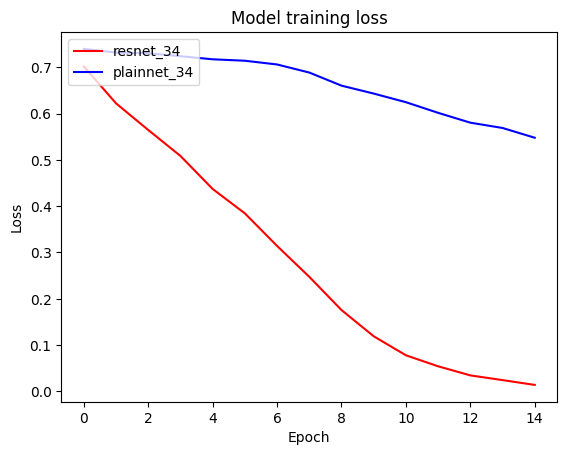

In [27]:
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plainnet_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

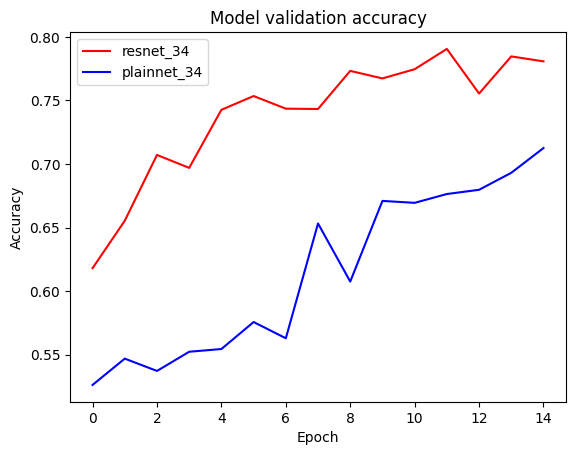

In [28]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plainnet_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

#### ResNet50 vs PlainNet50

In [29]:
checkpoint_path = "./best_model_ResNet50_catdog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:51 - loss: 0.8528 - accuracy: 0.5197

 40/581 [=>............................] - ETA: 1:48 - loss: 0.8497 - accuracy: 0.5242

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:36 - loss: 0.8084 - accuracy: 0.5459

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 53s - loss: 0.7757 - accuracy: 0.5679

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 50s - loss: 0.7733 - accuracy: 0.5686

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 48s - loss: 0.7718 - accuracy: 0.5705

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 42s - loss: 0.7696 - accuracy: 0.5719

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 41s - loss: 0.7691 - accuracy: 0.5723

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 0.7499 - accuracy: 0.5894

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7496 - accuracy: 0.5896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 1: val_accuracy improved from -inf to 0.58463, saving model to ./best_model_ResNet50_catdog.h5


/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


581/581 [==============================] - 153s 232ms/step - loss: 0.7496 - accuracy: 0.5896 - val_loss: 0.7746 - val_accuracy: 0.5846
Epoch 2/15
 22/581 [>.............................] - ETA: 1:52 - loss: 0.7274 - accuracy: 0.6250

 38/581 [>.............................] - ETA: 1:48 - loss: 0.7022 - accuracy: 0.6373

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:36 - loss: 0.7154 - accuracy: 0.6278

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 53s - loss: 0.7003 - accuracy: 0.6328

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 51s - loss: 0.6999 - accuracy: 0.6316

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 48s - loss: 0.7007 - accuracy: 0.6323

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 42s - loss: 0.7013 - accuracy: 0.6312

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 41s - loss: 0.6990 - accuracy: 0.6333

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.6363

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 2: val_accuracy improved from 0.58463 to 0.59589, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 130s 223ms/step - loss: 0.6955 - accuracy: 0.6363 - val_loss: 0.8130 - val_accuracy: 0.5959
Epoch 3/15
 20/581 [>.............................] - ETA: 1:52 - loss: 0.6942 - accuracy: 0.6547

 41/581 [=>............................] - ETA: 1:48 - loss: 0.6722 - accuracy: 0.6585

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:36 - loss: 0.6776 - accuracy: 0.6460

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 52s - loss: 0.6865 - accuracy: 0.6369

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 50s - loss: 0.6848 - accuracy: 0.6381

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 47s - loss: 0.6849 - accuracy: 0.6380

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 42s - loss: 0.6835 - accuracy: 0.6390

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 41s - loss: 0.6832 - accuracy: 0.6389

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.6421

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.6423

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 3: val_accuracy improved from 0.59589 to 0.63052, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 129s 222ms/step - loss: 0.6839 - accuracy: 0.6423 - val_loss: 0.7137 - val_accuracy: 0.6305
Epoch 4/15
 30/581 [>.............................] - ETA: 1:50 - loss: 0.6477 - accuracy: 0.6719

 41/581 [=>............................] - ETA: 1:55 - loss: 0.6463 - accuracy: 0.6692

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:35 - loss: 0.6686 - accuracy: 0.6635

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 52s - loss: 0.6697 - accuracy: 0.6610

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 50s - loss: 0.6708 - accuracy: 0.6597

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 47s - loss: 0.6682 - accuracy: 0.6609

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 42s - loss: 0.6675 - accuracy: 0.6610

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 40s - loss: 0.6657 - accuracy: 0.6618

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.6613

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 4: val_accuracy improved from 0.63052 to 0.63750, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 130s 224ms/step - loss: 0.6650 - accuracy: 0.6613 - val_loss: 0.7188 - val_accuracy: 0.6375
Epoch 5/15
  2/581 [..............................] - ETA: 1:56 - loss: 0.6474 - accuracy: 0.6875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 26/581 [>.............................] - ETA: 1:51 - loss: 0.6503 - accuracy: 0.6659

 43/581 [=>............................] - ETA: 1:48 - loss: 0.6611 - accuracy: 0.6606

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:33 - loss: 0.6639 - accuracy: 0.6489

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 52s - loss: 0.6437 - accuracy: 0.6705

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 50s - loss: 0.6438 - accuracy: 0.6710

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 47s - loss: 0.6429 - accuracy: 0.6711

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 42s - loss: 0.6426 - accuracy: 0.6702

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 40s - loss: 0.6409 - accuracy: 0.6710

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.6700

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 5: val_accuracy improved from 0.63750 to 0.65043, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 130s 223ms/step - loss: 0.6402 - accuracy: 0.6700 - val_loss: 0.8053 - val_accuracy: 0.6504
Epoch 6/15
  2/581 [..............................] - ETA: 1:56 - loss: 0.6713 - accuracy: 0.7031

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:50 - loss: 0.6248 - accuracy: 0.6857

 43/581 [=>............................] - ETA: 1:48 - loss: 0.6311 - accuracy: 0.6802

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:32 - loss: 0.6494 - accuracy: 0.6772

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 52s - loss: 0.6310 - accuracy: 0.6830

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 49s - loss: 0.6293 - accuracy: 0.6846

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 47s - loss: 0.6296 - accuracy: 0.6841

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 42s - loss: 0.6295 - accuracy: 0.6852

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 40s - loss: 0.6292 - accuracy: 0.6852

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.6811

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 6: val_accuracy improved from 0.65043 to 0.65238, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 130s 223ms/step - loss: 0.6303 - accuracy: 0.6811 - val_loss: 0.7062 - val_accuracy: 0.6524
Epoch 7/15
  4/581 [..............................] - ETA: 1:56 - loss: 0.6647 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:49 - loss: 0.5904 - accuracy: 0.7027

 42/581 [=>............................] - ETA: 1:47 - loss: 0.6044 - accuracy: 0.7009

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:32 - loss: 0.6112 - accuracy: 0.6870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 52s - loss: 0.6185 - accuracy: 0.6853

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 50s - loss: 0.6170 - accuracy: 0.6864

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 47s - loss: 0.6167 - accuracy: 0.6873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 42s - loss: 0.6158 - accuracy: 0.6870

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 40s - loss: 0.6174 - accuracy: 0.6859

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.6899

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 7: val_accuracy improved from 0.65238 to 0.65866, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 130s 223ms/step - loss: 0.6117 - accuracy: 0.6899 - val_loss: 0.7158 - val_accuracy: 0.6587
Epoch 8/15
  1/581 [..............................] - ETA: 1:57 - loss: 0.6920 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:50 - loss: 0.5923 - accuracy: 0.7074

 46/581 [=>............................] - ETA: 1:47 - loss: 0.5975 - accuracy: 0.7011

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:31 - loss: 0.6017 - accuracy: 0.6916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 51s - loss: 0.6054 - accuracy: 0.6970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 48s - loss: 0.6066 - accuracy: 0.6970

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 46s - loss: 0.6056 - accuracy: 0.6974

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 41s - loss: 0.6062 - accuracy: 0.6979

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 39s - loss: 0.6045 - accuracy: 0.6989

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5968 - accuracy: 0.7030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 8: val_accuracy improved from 0.65866 to 0.67091, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 127s 219ms/step - loss: 0.5968 - accuracy: 0.7030 - val_loss: 0.7129 - val_accuracy: 0.6709
Epoch 9/15
  6/581 [..............................] - ETA: 1:55 - loss: 0.6200 - accuracy: 0.6615

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 2:01 - loss: 0.5997 - accuracy: 0.6964

 47/581 [=>............................] - ETA: 1:52 - loss: 0.6039 - accuracy: 0.7068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:32 - loss: 0.5979 - accuracy: 0.6983

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 51s - loss: 0.5894 - accuracy: 0.7044

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 48s - loss: 0.5888 - accuracy: 0.7047

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 46s - loss: 0.5867 - accuracy: 0.7057

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 41s - loss: 0.5851 - accuracy: 0.7079

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 39s - loss: 0.5846 - accuracy: 0.7082

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.7122

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 9: val_accuracy improved from 0.67091 to 0.68966, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 127s 219ms/step - loss: 0.5795 - accuracy: 0.7122 - val_loss: 0.6456 - val_accuracy: 0.6897
Epoch 10/15
  4/581 [..............................] - ETA: 1:52 - loss: 0.5683 - accuracy: 0.7031

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:47 - loss: 0.5485 - accuracy: 0.7448

 47/581 [=>............................] - ETA: 1:51 - loss: 0.5534 - accuracy: 0.7374

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:32 - loss: 0.5787 - accuracy: 0.7214

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 50s - loss: 0.5701 - accuracy: 0.7208

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 48s - loss: 0.5702 - accuracy: 0.7210

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 45s - loss: 0.5688 - accuracy: 0.7211

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 40s - loss: 0.5687 - accuracy: 0.7216

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 39s - loss: 0.5685 - accuracy: 0.7216

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7205

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 10: val_accuracy improved from 0.68966 to 0.70736, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 127s 219ms/step - loss: 0.5697 - accuracy: 0.7205 - val_loss: 0.6232 - val_accuracy: 0.7074
Epoch 11/15
  5/581 [..............................] - ETA: 1:53 - loss: 0.5742 - accuracy: 0.7125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 1:46 - loss: 0.5750 - accuracy: 0.7196

 51/581 [=>............................] - ETA: 1:44 - loss: 0.5723 - accuracy: 0.7151

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:30 - loss: 0.5731 - accuracy: 0.7126

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 50s - loss: 0.5480 - accuracy: 0.7305

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 47s - loss: 0.5499 - accuracy: 0.7294

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 45s - loss: 0.5495 - accuracy: 0.7298

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 39s - loss: 0.5510 - accuracy: 0.7303

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 38s - loss: 0.5509 - accuracy: 0.7298

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5465 - accuracy: 0.7324

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 11: val_accuracy did not improve from 0.70736
581/581 [==============================] - 126s 218ms/step - loss: 0.5465 - accuracy: 0.7324 - val_loss: 0.6212 - val_accuracy: 0.7063
Epoch 12/15
  7/581 [..............................] - ETA: 1:52 - loss: 0.5119 - accuracy: 0.7366

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 2:01 - loss: 0.5601 - accuracy: 0.7153

 52/581 [=>............................] - ETA: 1:50 - loss: 0.5275 - accuracy: 0.7410

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:31 - loss: 0.5323 - accuracy: 0.7423

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 50s - loss: 0.5292 - accuracy: 0.7437

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 47s - loss: 0.5289 - accuracy: 0.7436

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 45s - loss: 0.5275 - accuracy: 0.7439

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 40s - loss: 0.5277 - accuracy: 0.7444

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 38s - loss: 0.5272 - accuracy: 0.7445

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7465

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 12: val_accuracy did not improve from 0.70736
581/581 [==============================] - 127s 218ms/step - loss: 0.5217 - accuracy: 0.7465 - val_loss: 0.8061 - val_accuracy: 0.6440
Epoch 13/15
 10/581 [..............................] - ETA: 1:52 - loss: 0.5537 - accuracy: 0.7312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:55 - loss: 0.5186 - accuracy: 0.7508

 50/581 [=>............................] - ETA: 1:51 - loss: 0.5096 - accuracy: 0.7513

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:32 - loss: 0.5184 - accuracy: 0.7513

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 50s - loss: 0.5143 - accuracy: 0.7592

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 47s - loss: 0.5129 - accuracy: 0.7597

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 44s - loss: 0.5137 - accuracy: 0.7593

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 39s - loss: 0.5105 - accuracy: 0.7603

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 38s - loss: 0.5107 - accuracy: 0.7600

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 13: val_accuracy improved from 0.70736 to 0.72155, saving model to ./best_model_ResNet50_catdog.h5
581/581 [==============================] - 127s 219ms/step - loss: 0.5077 - accuracy: 0.7620 - val_loss: 0.6571 - val_accuracy: 0.7216
Epoch 14/15
 11/581 [..............................] - ETA: 1:51 - loss: 0.5579 - accuracy: 0.7244

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:46 - loss: 0.5092 - accuracy: 0.7586

 51/581 [=>............................] - ETA: 1:44 - loss: 0.4915 - accuracy: 0.7708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 1:31 - loss: 0.5034 - accuracy: 0.7673

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 49s - loss: 0.5043 - accuracy: 0.7616

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 47s - loss: 0.5061 - accuracy: 0.7604

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 45s - loss: 0.5054 - accuracy: 0.7610

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 39s - loss: 0.5043 - accuracy: 0.7615

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 38s - loss: 0.5033 - accuracy: 0.7616

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.7640

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 14: val_accuracy did not improve from 0.72155
581/581 [==============================] - 127s 218ms/step - loss: 0.4996 - accuracy: 0.7640 - val_loss: 0.8411 - val_accuracy: 0.6659
Epoch 15/15
 12/581 [..............................] - ETA: 1:51 - loss: 0.5181 - accuracy: 0.7474

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 1:47 - loss: 0.4997 - accuracy: 0.7671

 52/581 [=>............................] - ETA: 1:43 - loss: 0.4697 - accuracy: 0.7812

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 1:31 - loss: 0.4731 - accuracy: 0.7800

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 49s - loss: 0.4599 - accuracy: 0.7868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 47s - loss: 0.4584 - accuracy: 0.7874

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 44s - loss: 0.4571 - accuracy: 0.7873

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 39s - loss: 0.4582 - accuracy: 0.7866

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


391/581 [===================>..........] - ETA: 37s - loss: 0.4587 - accuracy: 0.7864

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.7850

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 15: val_accuracy did not improve from 0.72155
581/581 [==============================] - 126s 218ms/step - loss: 0.4610 - accuracy: 0.7850 - val_loss: 0.6425 - val_accuracy: 0.7114


In [30]:
checkpoint_path = "./best_model_PlainNet50_catdog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint]
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 1:35 - loss: 0.7718 - accuracy: 0.5000

 39/581 [=>............................] - ETA: 1:32 - loss: 0.7581 - accuracy: 0.5064

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


103/581 [====>.........................] - ETA: 1:20 - loss: 0.7578 - accuracy: 0.5240

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 44s - loss: 0.7550 - accuracy: 0.5301

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 0.7549 - accuracy: 0.5307

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.7548 - accuracy: 0.5295

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 0.7562 - accuracy: 0.5283

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 34s - loss: 0.7559 - accuracy: 0.5282

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.7534 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.5310

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 1: val_accuracy improved from -inf to 0.52823, saving model to ./best_model_PlainNet50_catdog.h5


/home/cho/anaconda3/envs/GPU/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


581/581 [==============================] - 126s 194ms/step - loss: 0.7536 - accuracy: 0.5310 - val_loss: 0.8000 - val_accuracy: 0.5282
Epoch 2/15
 20/581 [>.............................] - ETA: 1:33 - loss: 0.7740 - accuracy: 0.5000

 39/581 [=>............................] - ETA: 1:30 - loss: 0.7599 - accuracy: 0.5160

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:20 - loss: 0.7495 - accuracy: 0.5293

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 44s - loss: 0.7519 - accuracy: 0.5367

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 42s - loss: 0.7516 - accuracy: 0.5368

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.7507 - accuracy: 0.5378

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 0.7508 - accuracy: 0.5368

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 0.7509 - accuracy: 0.5369

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.5357

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 2: val_accuracy improved from 0.52823 to 0.56126, saving model to ./best_model_PlainNet50_catdog.h5
581/581 [==============================] - 109s 186ms/step - loss: 0.7492 - accuracy: 0.5357 - val_loss: 0.8273 - val_accuracy: 0.5613
Epoch 3/15
  1/581 [..............................] - ETA: 1:37 - loss: 0.7033 - accuracy: 0.6875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 19/581 [..............................] - ETA: 1:53 - loss: 0.7672 - accuracy: 0.5181

 42/581 [=>............................] - ETA: 1:39 - loss: 0.7622 - accuracy: 0.5335

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:21 - loss: 0.7596 - accuracy: 0.5304

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 44s - loss: 0.7529 - accuracy: 0.5317

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 42s - loss: 0.7532 - accuracy: 0.5320

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.7521 - accuracy: 0.5320

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 0.7523 - accuracy: 0.5337

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.7514 - accuracy: 0.5343

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.7528 - accuracy: 0.5331

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7525 - accuracy: 0.5333

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 3: val_accuracy did not improve from 0.56126
581/581 [==============================] - 109s 187ms/step - loss: 0.7525 - accuracy: 0.5333 - val_loss: 0.9309 - val_accuracy: 0.5102
Epoch 4/15
 31/581 [>.............................] - ETA: 1:31 - loss: 0.7710 - accuracy: 0.5302

 43/581 [=>............................] - ETA: 1:29 - loss: 0.7657 - accuracy: 0.5327

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 1:17 - loss: 0.7597 - accuracy: 0.5328

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 43s - loss: 0.7550 - accuracy: 0.5379

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 41s - loss: 0.7538 - accuracy: 0.5389

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 39s - loss: 0.7537 - accuracy: 0.5385

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 0.7524 - accuracy: 0.5379

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.7535 - accuracy: 0.5383

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.5416

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 4: val_accuracy did not improve from 0.56126
581/581 [==============================] - 108s 186ms/step - loss: 0.7487 - accuracy: 0.5416 - val_loss: 0.8412 - val_accuracy: 0.5541
Epoch 5/15
 32/581 [>.............................] - ETA: 1:35 - loss: 0.7450 - accuracy: 0.5515

 41/581 [=>............................] - ETA: 1:32 - loss: 0.7440 - accuracy: 0.5493

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:16 - loss: 0.7412 - accuracy: 0.5424

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 43s - loss: 0.7460 - accuracy: 0.5352

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 41s - loss: 0.7462 - accuracy: 0.5355

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 39s - loss: 0.7456 - accuracy: 0.5362

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 34s - loss: 0.7453 - accuracy: 0.5363

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 33s - loss: 0.7440 - accuracy: 0.5365

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.7462 - accuracy: 0.5375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7464 - accuracy: 0.5370

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 5: val_accuracy did not improve from 0.56126
581/581 [==============================] - 108s 186ms/step - loss: 0.7464 - accuracy: 0.5370 - val_loss: 0.8182 - val_accuracy: 0.5159
Epoch 6/15
 31/581 [>.............................] - ETA: 1:32 - loss: 0.7447 - accuracy: 0.5524

 43/581 [=>............................] - ETA: 1:30 - loss: 0.7402 - accuracy: 0.5509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:18 - loss: 0.7366 - accuracy: 0.5519

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 43s - loss: 0.7466 - accuracy: 0.5394

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 41s - loss: 0.7462 - accuracy: 0.5398

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 39s - loss: 0.7476 - accuracy: 0.5388

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 34s - loss: 0.7483 - accuracy: 0.5394

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 33s - loss: 0.7482 - accuracy: 0.5391

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7488 - accuracy: 0.5372

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 6: val_accuracy did not improve from 0.56126
581/581 [==============================] - 108s 186ms/step - loss: 0.7488 - accuracy: 0.5372 - val_loss: 0.7534 - val_accuracy: 0.5355
Epoch 7/15
  1/581 [..............................] - ETA: 1:37 - loss: 0.6904 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:32 - loss: 0.7607 - accuracy: 0.5039

 45/581 [=>............................] - ETA: 1:30 - loss: 0.7497 - accuracy: 0.5236

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:17 - loss: 0.7443 - accuracy: 0.5215

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 43s - loss: 0.7465 - accuracy: 0.5346

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 41s - loss: 0.7477 - accuracy: 0.5357

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 39s - loss: 0.7483 - accuracy: 0.5358

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 34s - loss: 0.7473 - accuracy: 0.5352

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 33s - loss: 0.7481 - accuracy: 0.5354

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.5377

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 7: val_accuracy did not improve from 0.56126
581/581 [==============================] - 108s 186ms/step - loss: 0.7456 - accuracy: 0.5377 - val_loss: 0.7907 - val_accuracy: 0.5409
Epoch 8/15
  2/581 [..............................] - ETA: 1:37 - loss: 0.7314 - accuracy: 0.6094

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:32 - loss: 0.7574 - accuracy: 0.5449

 45/581 [=>............................] - ETA: 1:30 - loss: 0.7509 - accuracy: 0.5562

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:18 - loss: 0.7400 - accuracy: 0.5469

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 43s - loss: 0.7398 - accuracy: 0.5454

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 41s - loss: 0.7380 - accuracy: 0.5466

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 39s - loss: 0.7367 - accuracy: 0.5471

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 34s - loss: 0.7372 - accuracy: 0.5487

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 33s - loss: 0.7371 - accuracy: 0.5494

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.5558

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 8: val_accuracy did not improve from 0.56126
581/581 [==============================] - 108s 186ms/step - loss: 0.7374 - accuracy: 0.5558 - val_loss: 0.8311 - val_accuracy: 0.5595
Epoch 9/15
  1/581 [..............................] - ETA: 1:37 - loss: 0.6810 - accuracy: 0.6250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:32 - loss: 0.7084 - accuracy: 0.5750

 46/581 [=>............................] - ETA: 1:31 - loss: 0.7177 - accuracy: 0.5679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:18 - loss: 0.7244 - accuracy: 0.5690

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 0.7333 - accuracy: 0.5588

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 41s - loss: 0.7336 - accuracy: 0.5601

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 38s - loss: 0.7340 - accuracy: 0.5597

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.7356 - accuracy: 0.5576

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 33s - loss: 0.7352 - accuracy: 0.5580

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7354 - accuracy: 0.5620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 9: val_accuracy improved from 0.56126 to 0.56905, saving model to ./best_model_PlainNet50_catdog.h5
581/581 [==============================] - 109s 187ms/step - loss: 0.7354 - accuracy: 0.5620 - val_loss: 1.3719 - val_accuracy: 0.5690
Epoch 10/15
  5/581 [..............................] - ETA: 1:38 - loss: 0.7700 - accuracy: 0.6187

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:32 - loss: 0.7297 - accuracy: 0.5830

 46/581 [=>............................] - ETA: 1:31 - loss: 0.7276 - accuracy: 0.5679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:17 - loss: 0.7338 - accuracy: 0.5452

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 42s - loss: 0.7403 - accuracy: 0.5493

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 41s - loss: 0.7422 - accuracy: 0.5488

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 38s - loss: 0.7416 - accuracy: 0.5509

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.7416 - accuracy: 0.5508

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 33s - loss: 0.7413 - accuracy: 0.5511

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.5542

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 10: val_accuracy did not improve from 0.56905
581/581 [==============================] - 108s 186ms/step - loss: 0.7385 - accuracy: 0.5542 - val_loss: 1.1033 - val_accuracy: 0.5608
Epoch 11/15
  7/581 [..............................] - ETA: 1:37 - loss: 0.7293 - accuracy: 0.5804

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:31 - loss: 0.7315 - accuracy: 0.5617

 50/581 [=>............................] - ETA: 1:29 - loss: 0.7383 - accuracy: 0.5556

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:18 - loss: 0.7240 - accuracy: 0.5656

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 42s - loss: 0.7318 - accuracy: 0.5618

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 40s - loss: 0.7315 - accuracy: 0.5621

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 38s - loss: 0.7308 - accuracy: 0.5630

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 0.7319 - accuracy: 0.5626

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 33s - loss: 0.7311 - accuracy: 0.5635

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.5627

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 11: val_accuracy improved from 0.56905 to 0.56926, saving model to ./best_model_PlainNet50_catdog.h5
581/581 [==============================] - 108s 186ms/step - loss: 0.7359 - accuracy: 0.5627 - val_loss: 1.0574 - val_accuracy: 0.5693
Epoch 12/15
  8/581 [..............................] - ETA: 1:36 - loss: 0.6679 - accuracy: 0.5820

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:40 - loss: 0.7213 - accuracy: 0.5790

 50/581 [=>............................] - ETA: 1:35 - loss: 0.7320 - accuracy: 0.5888

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 1:17 - loss: 0.7324 - accuracy: 0.5835

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 42s - loss: 0.7390 - accuracy: 0.5659

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 40s - loss: 0.7371 - accuracy: 0.5679

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 38s - loss: 0.7378 - accuracy: 0.5670

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.7378 - accuracy: 0.5652

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 0.7374 - accuracy: 0.5646

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.5656

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 12: val_accuracy improved from 0.56926 to 0.57414, saving model to ./best_model_PlainNet50_catdog.h5
581/581 [==============================] - 109s 187ms/step - loss: 0.7336 - accuracy: 0.5656 - val_loss: 0.9639 - val_accuracy: 0.5741
Epoch 13/15
  7/581 [..............................] - ETA: 1:39 - loss: 0.7568 - accuracy: 0.5357

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 1:32 - loss: 0.7506 - accuracy: 0.5625

 51/581 [=>............................] - ETA: 1:30 - loss: 0.7538 - accuracy: 0.5662

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:18 - loss: 0.7440 - accuracy: 0.5648

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 42s - loss: 0.7328 - accuracy: 0.5700

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 40s - loss: 0.7325 - accuracy: 0.5712

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 38s - loss: 0.7318 - accuracy: 0.5711

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 33s - loss: 0.7322 - accuracy: 0.5722

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 32s - loss: 0.7322 - accuracy: 0.5720

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7282 - accuracy: 0.5773

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 13: val_accuracy did not improve from 0.57414
581/581 [==============================] - 110s 189ms/step - loss: 0.7282 - accuracy: 0.5773 - val_loss: 0.9146 - val_accuracy: 0.5738
Epoch 14/15
  8/581 [..............................] - ETA: 1:36 - loss: 0.7889 - accuracy: 0.5859

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:30 - loss: 0.7184 - accuracy: 0.5885

 52/581 [=>............................] - ETA: 1:28 - loss: 0.7307 - accuracy: 0.5921

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 0.7279 - accuracy: 0.5938

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 42s - loss: 0.7205 - accuracy: 0.5879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.7232 - accuracy: 0.5873

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 38s - loss: 0.7227 - accuracy: 0.5884

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 33s - loss: 0.7235 - accuracy: 0.5903

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 32s - loss: 0.7233 - accuracy: 0.5901

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.5945

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 14: val_accuracy improved from 0.57414 to 0.59892, saving model to ./best_model_PlainNet50_catdog.h5
581/581 [==============================] - 109s 187ms/step - loss: 0.7178 - accuracy: 0.5945 - val_loss: 1.0371 - val_accuracy: 0.5989
Epoch 15/15
 14/581 [..............................] - ETA: 1:35 - loss: 0.7747 - accuracy: 0.5513

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:32 - loss: 0.7425 - accuracy: 0.5906

 54/581 [=>............................] - ETA: 1:33 - loss: 0.7213 - accuracy: 0.6019

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 1:18 - loss: 0.7053 - accuracy: 0.6115

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 42s - loss: 0.7085 - accuracy: 0.6084

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.7085 - accuracy: 0.6091

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 38s - loss: 0.7086 - accuracy: 0.6096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 33s - loss: 0.7088 - accuracy: 0.6099

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 32s - loss: 0.7091 - accuracy: 0.6097

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.6087

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9



Epoch 15: val_accuracy did not improve from 0.59892
581/581 [==============================] - 109s 187ms/step - loss: 0.7076 - accuracy: 0.6087 - val_loss: 0.9383 - val_accuracy: 0.5875


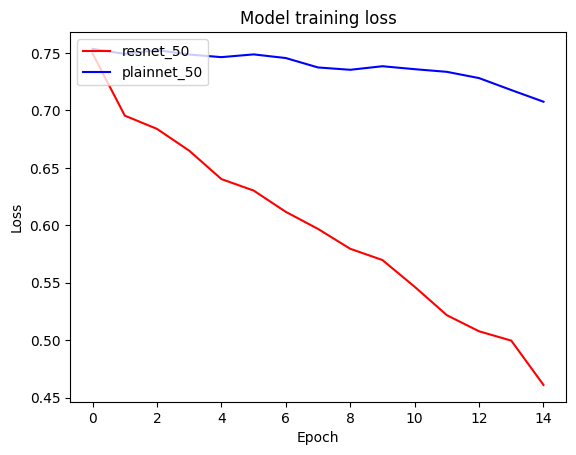

In [31]:
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plainnet_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

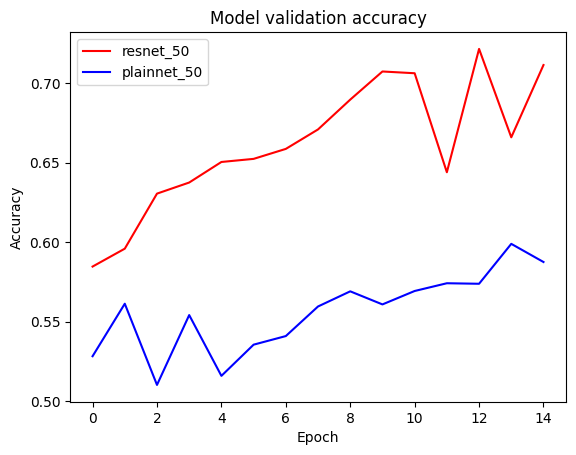

In [32]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plainnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

In [33]:
import json

# 학습 로그 저장
with open("./history_plainnet_50.json", "w") as f:
    json.dump(history_plainnet_50.history, f)

with open("./history_resnet_50.json", "w") as f:
    json.dump(history_resnet_50.history, f)

with open("./history_plainnet_34.json", "w") as f:
    json.dump(history_plainnet_34.history, f)

with open("./history_resnet_34.json", "w") as f:
    json.dump(history_resnet_34.history, f)


### 회고

내가 나름대로 작성한 ResNet50에서 의문이 들었던 부분이 2가지 있다.

- 첫 번째로 stage가 바뀌는 부분(반복되는 블럭이 바뀌는 부분)에서 stride를 적용시켜 서로 다른 수준의 특징이 추출될 수 있도록 해야 하는데, 노드에서 제공하는 모델 요약 내용을 살펴보면 1x1 Conv층에 stride를 적용하는 것을 확인 할 수 있다. 하지만 직접 작성할 때에는 1x1 Conv층에 stride를 적용하는 것 보다는 3x3 Conv층에서 stride를 적용하는게 다양한 수준의 특징이 추출될 수 있다고 생각하여 노드의 내용과 조금 다르게 구현하게 되었다. 따라서 1x1 Conv층에 stride를 적용하는 것이 맞는지, 맞다면 그 이유가 무엇인지 정리할 필요가 있어 추후에 지금 작성한 내용을 보완할 것이다.


- 두 번째로는 PlainNet을 구성하는데 50에서 34보다 학습가능한 파라미터가 더 적다는 것이다. 레이어 수가 늘어났음에도 residual connection을 빼면 학습가능한 파라미터 수가 더 적은 이유가 무엇인지 명확히 설명할 수 없어, 해당 내용을 추후에 보완해야 한다.

이 두가지 의문을 제외하고 실험결과를 관찰해보면 레이어 수가 늘어날수록 residual connection의 중요성이 더 커지는 것을 확인할 수 있어서 ResNet이 제안했던 내용이 실제로 적용됨을 확인할 수 있었던 시간이었다.